https://www.kaggle.com/c/competitive-data-science-final-project

In [64]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
%matplotlib inline 

import utility.utility as ut
from preprocessing.createSets import *

########### switches ################################

saveName='Oct11-2018_1'
saveFolder = saveName
saveplots=False
createSubmit = False
if not os.path.exists(saveFolder) and (saveplots or createSubmit): 
    print 'creating folder:',os.getcwd()+'/'+saveFolder
    os.mkdir(saveFolder)
if(saveplots): print "SAVING PLOTS!"
if(createSubmit): print "WILL CREATE SUBMIT FILE!"


############# Some things More #########################

#columns to keep
#col_to_keep = ['shop_id','item_id','item_price','item_category_id','item_cnt_day']
col_to_keep = ['shop_id','item_id','item_category_id','item_cnt_day']

groupby_list = ['shop_id','item_id']

#agg_dict = {'item_price':'mean','item_category_id':'mean','item_cnt_day':'sum'}
agg_dict = {'item_category_id':'mean','item_cnt_day':'sum'}
agg_targ = {'item_cnt_day':'sum'}

col_targets=['shop_item_cnt_month',
             'shop_cnt_month',
             'item_cnt_month',
             'shop_item_cnt_month_diff(0-1)',
             'shop_cnt_month_diff(0-1)',
             'item_cnt_month_diff(0-1)']

more_opts = {'col_to_keep':col_to_keep,
             'groupby_list':groupby_list,
             'agg_dict':agg_dict,
             'agg_targ':agg_targ,
             'col_targets':col_targets,            
            }

target = 'shop_item_cnt_month'
# target = 'shop_item_cnt_month_diff(0-1)'

######## feat options #####################################

feat_opt = {'lag_length':3,
            'diff':True,
            'diffRel':False,
            'item_cat_count_feat':False,
            'target':target,
           } 
    
clipTarget = True
lowerClip = 0
upperClip = 20
if target=='shop_item_cnt_month_diff(0-1)':
    lowerClip = -20
    upperClip = 20    

########################################################


# create train/val/test set

In [88]:
data = getData()

kwargz = data.copy()
kwargz.update(feat_opt)
kwargz.update(more_opts)

x_train, y_train = createTrainSet(**kwargz)
x_val, y_val = createValSet(**kwargz)
x_test = createTestSet(**kwargz)

x_train.shape : (51460, 18)
y_train.shape : (51460,)
x_val.shape : (45755, 18)
y_val.shape : (45755,)
x_test.shape : (214200, 18)


In [89]:
#combine 2013+2014
# x_train  = pd.concat([x_train, x_val], ignore_index=True)
# y_train  = pd.concat([y_train, y_val], ignore_index=True)
# x_train.shape

In [90]:
nbins=20

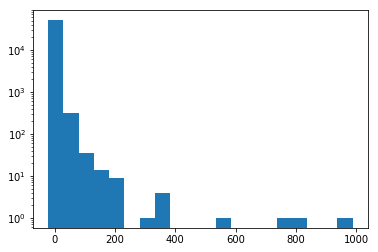

In [91]:
hist_y_train = plt.hist(y_train,nbins,log=True)
# counts = hist_y_train[0]
# bin_edges = hist_y_train[1]
# ut.hist_integrals(nbins,counts,bin_edges)

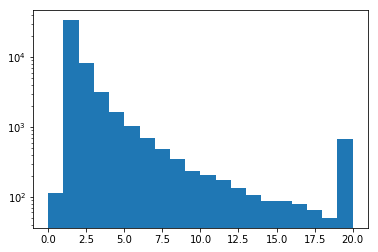

In [92]:
y_train_clip = np.clip(y_train,lowerClip,upperClip)
hist_y_train_clip = plt.hist(y_train_clip,nbins,log=True)
#hist_y_train_clip = sns.distplot(y_train_clip,bins=nbins,kde=False,hist_kws={'log':True})
#hist_y_train_clip.set_yscale('log')

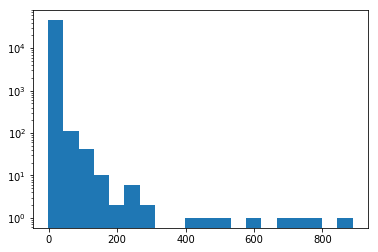

In [93]:
his_y_val = plt.hist(y_val,nbins,log=True)

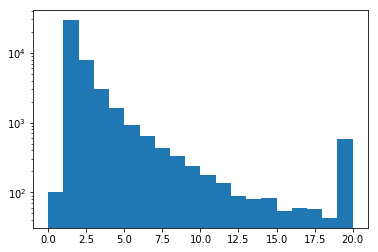

In [94]:
y_val_clip = np.clip(y_val,lowerClip,upperClip)
his_y_val_clip = plt.hist(y_val_clip,nbins,log=True)
#hist_y_val_clip = sns.distplot(y_train_clip,bins=nbins,kde=False,hist_kws={'log':True})
#hist_y_val_clip.set_yscale('log')

In [95]:
print 'Sum y_train before clip:',np.sum(y_train)
print 'Sum y_val before clip:', np.sum(y_val)
if(clipTarget):
    y_train=y_train_clip
    y_val=y_val_clip
print 'Sum y_train after clip:',np.sum(y_train)
print 'Sum y_val after clip:', np.sum(y_val)

Sum y_train before clip: 130009.0
Sum y_val before clip: 117845.0
Sum y_train after clip: 110388.0
Sum y_val after clip: 98404.0


# Model training

In [100]:
### Boosted Decision Tree (lightgbm)

import lightgbm as lgb
from sklearn.metrics import r2_score

evals_result={}

lgb_train = lgb.Dataset(x_train, label=y_train)
lgb_test = lgb.Dataset(x_val, label=y_val)

lgb_params = {
               'feature_fraction': .75,
               'metric': 'rmse',
               'nthread':4, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75,#0.75 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':1,
              }

num_boost_round = 1000
verbose_eval = num_boost_round/20
model = lgb.train(lgb_params, 
                  lgb_train,
                  valid_sets=[lgb_train, lgb_test],
                  valid_names=['train','eval'],
                  num_boost_round=num_boost_round,
                  evals_result=evals_result,
                  early_stopping_rounds=200,
                  verbose_eval=verbose_eval)

#print 'evals_result = ',evals_result

Training until validation scores don't improve for 200 rounds.
[50]	train's rmse: 1.99852	eval's rmse: 2.22734
[100]	train's rmse: 1.78785	eval's rmse: 2.16319
[150]	train's rmse: 1.67905	eval's rmse: 2.16509
[200]	train's rmse: 1.6084	eval's rmse: 2.17639
[250]	train's rmse: 1.55835	eval's rmse: 2.19191
[300]	train's rmse: 1.52076	eval's rmse: 2.20812
Early stopping, best iteration is:
[134]	train's rmse: 1.70948	eval's rmse: 2.1617


Plot metrics recorded during training...


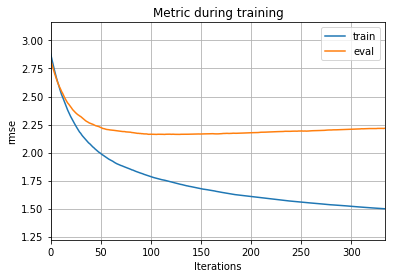

Plot feature importances...


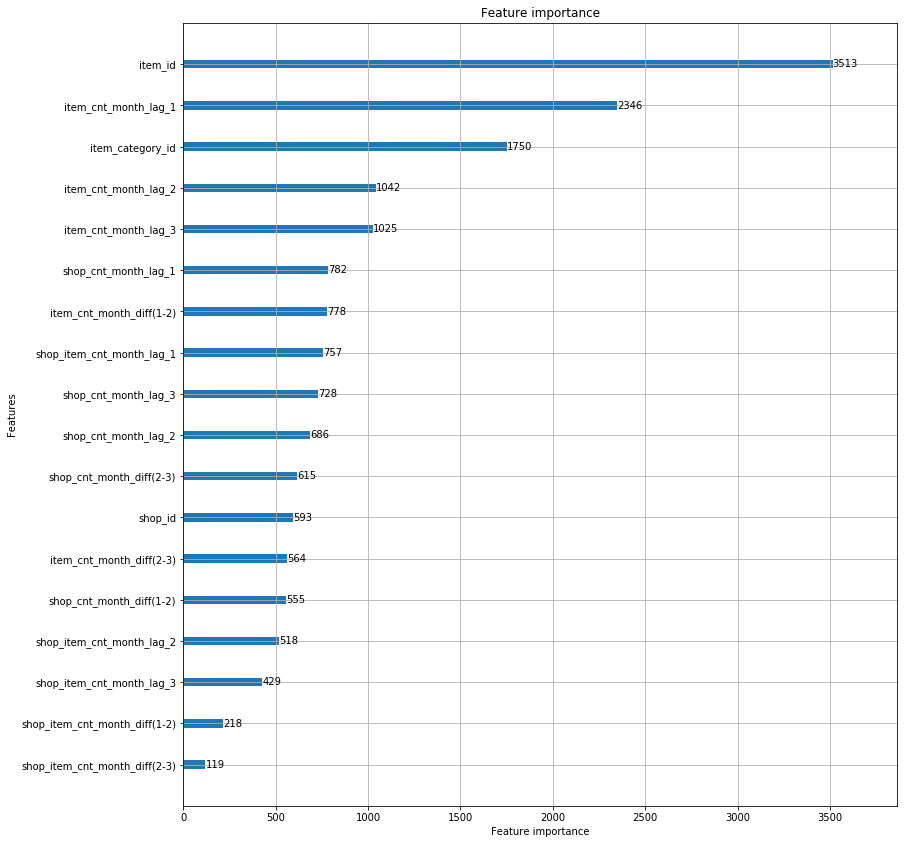

In [101]:
print('Plot metrics recorded during training...')
ax = lgb.plot_metric(evals_result, metric='rmse')
if(saveplots):plt.savefig(saveFolder+"/"+"lgb_plot_metric_"+saveName+".pdf")
plt.show()

print('Plot feature importances...')
ax = lgb.plot_importance(model, max_num_features=x_test.shape[1])
ax.figure.set_size_inches(6.4*2,4.8*3)
if(saveplots):plt.savefig(saveFolder+"/"+"lgb_plot_importance_"+saveName+".pdf")
plt.show()

In [102]:
pred_lgb = model.predict(x_train)
print('Training R-squared for LightGBM is %f' % r2_score(y_train, pred_lgb))

Training R-squared for LightGBM is 0.658834


In [103]:
pred_lgb = model.predict(x_val)
print('Validation R-squared for LightGBM is %f' % r2_score(y_val, pred_lgb))

Validation R-squared for LightGBM is 0.429254


# Predict with test data

In [104]:
pred = model.predict(x_test)

In [105]:
print pred.size
print pred
print 'Sum pred:',np.sum(pred)
pred_submit = pred

214200
[1.17701803 1.42091134 1.35244263 ... 1.1317638  1.13905354 1.20658296]
Sum pred: 300560.87825323775


In [106]:
#translate back to shop_item_cnt_month in needed
if target =='shop_item_cnt_month_diff(0-1)':  
    last_month_shop_item_cnt_month = sales_2015[sales_2015['month']==(10)].groupby(groupby_list,as_index=False).agg(agg_dict).rename(columns={'item_cnt_day':'shop_item_cnt_month_lag_1'})
    last_month_shop_item_cnt_month = last_month_shop_item_cnt_month[['shop_id','item_id','shop_item_cnt_month_lag_1']].head()
    df_temp = pd.merge(x_test[['shop_id','item_id']],last_month_shop_item_cnt_month,on=('shop_id','item_id'),how='left')
    df_temp.fillna(0,inplace=True)
    df_temp.head()

    df_pred = pd.DataFrame(pred,columns=['y_pred_residual'])
    df_pred.head()

    df_pred['y_pred'] = df_temp['shop_item_cnt_month_lag_1'] + df_pred['y_pred_residual']
    df_pred.head()

    pred_submit = df_pred['y_pred'].values
    
# True target values are clipped into [0,20] range.
pred_submit = np.clip(pred_submit,0,20)
    
print pred_submit

[1.17701803 1.42091134 1.35244263 ... 1.1317638  1.13905354 1.20658296]


In [113]:
### adhoc scaling
#pred_submit = (pred_submit)*0.25 
#pred_submit = np.floor(pred_submit)
print pred_submit

[0.29425451 0.35522783 0.33811066 ... 0.28294095 0.28476338 0.30164574]


total sales pred: 75140.21956330944


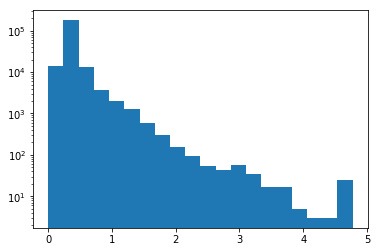

In [114]:
print 'total sales pred:',np.sum(pred_submit)
hist_pred = plt.hist(pred_submit,nbins,log=True)

# Validation with yearly trend (BDT)

total sales count from Oct11-2018_1 prediction: 75140.21956330944
total sales count from contant 0.5 prediction: 107100.0


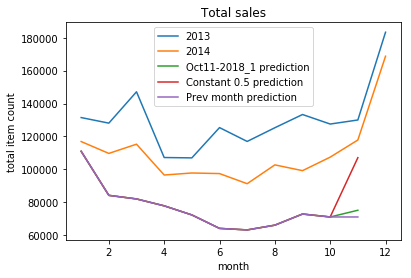

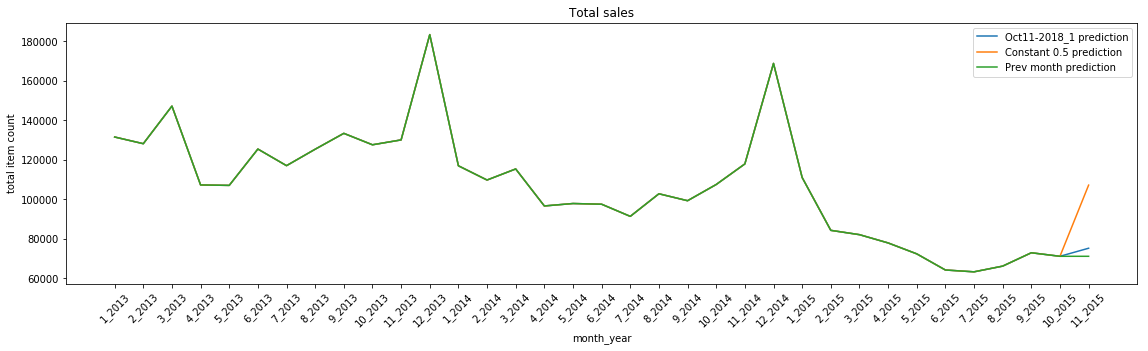

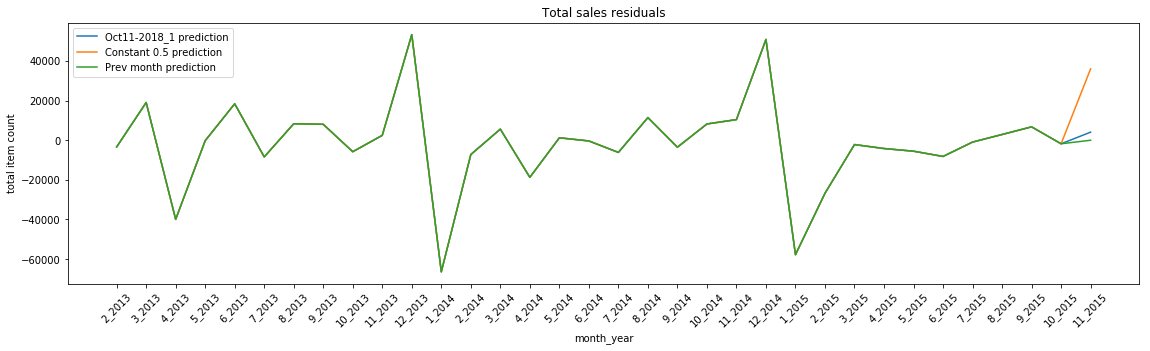

In [115]:
y_test = pd.DataFrame(pred_submit,columns=['item_cnt_month'])
#saveName='constant_0p38'
#saveplots=True

total_item_cnt_2013 = data['sales_2013'].groupby(['date_block_num','Y_M'])['item_cnt_day'].sum().values
total_item_cnt_2014 = data['sales_2014'].groupby(['date_block_num','Y_M'])['item_cnt_day'].sum().values
total_item_cnt_2015 = data['sales_2015'].groupby(['date_block_num','Y_M'])['item_cnt_day'].sum().values
yearlySales = [total_item_cnt_2013,total_item_cnt_2014,total_item_cnt_2015]

kwargs = {'yearlySales':yearlySales,
        'y_test':y_test,
        'saveName':saveName,
        'saveplots':saveplots,
        'saveFolder':saveFolder}

ut.plotYearly(**kwargs)
ut.plotYearly_v2(**kwargs)
ut.plotResidual(**kwargs)

# Prepare submission file

In [116]:
test_sorted = data['test'].sort_values(by=groupby_list).reset_index(drop=True)
submit = pd.concat([test_sorted,y_test],axis=1)
submit = submit.sort_values(by="ID").reset_index(drop=True)

# sanity check
print 'These numbers below should match:'
print 'y_test.iloc[0] =',y_test.iloc[0].values[0] 
print 'submit[submit["ID"]==22987] = ',submit[submit["ID"]==22987]["item_cnt_month"].values[0]

submit = submit[["item_cnt_month"]]
submit.index.name="ID"
submit.head()

submitName=''
if submitName=='': 
    submitName=saveName
if(createSubmit):submit.to_csv('submit_'+submitName+'.csv')

These numbers below should match:
y_test.iloc[0] = 0.29425450783217383
submit[submit["ID"]==22987] =  0.29425450783217383
